# Measure and Optimize Comparer queries - Test Nearest Neighborood
@ ishapira, 10/23

**Objective:** test find_nearest_neighbors fuction



In [1]:
# **Import necessary libraries**
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import re
from generative_social_choice.objects.agents import MultiLevelAgent

from generative_social_choice.objects.comparers import BasicComparer
from utils.gpt_wrapper import  prompt_gpt
from tqdm import tqdm
from generative_social_choice.datasets.datasets import get_dataset
from generative_social_choice.experiments.prolific_approval_query_eval.create_agents import (
    extract_statement_from_question,
)


In [2]:
# Load the dataset and extract agent comments.
dataset = get_dataset("prolific")
df = dataset.load()
experiment_name = 'chatbot_personalization_eval_23_09_28_strict'

agent_ids = dataset.get_agent_ids()[experiment_name]

agent_ids_to_comment = {
    agent_id: dataset.get_transcript_from_agent_id(agent_id)[
        dataset.get_transcript_from_agent_id(agent_id)["step"] == 7
    ]["text"].values[0]
    for agent_id in agent_ids
}

In [3]:
# Create a list of MultiLevelAgent objects based on extracted comments.

approval_level = 5

agents = [
    MultiLevelAgent(
        id=agent_id,
        prompt_type="basic",
        approval_level=approval_level,
        agent_opinion=comment,
    )
    for agent_id, comment in agent_ids_to_comment.items()
]

# Initializing the comparer object
comparer = BasicComparer(id=0, prompt_type="basic")

### Test the get_closest_agent_idx function and the find_nearest_neighbors method.


In [5]:
center_agent = agents[7]
other_agents = list(set(agents).difference({center_agent}))

# For demonstration purposes, just taking the first three agents other than center_agent
agent_sample = other_agents[:3]

closest_agent_idx, log_dict = comparer.get_closest_agent_idx(
    center_agent=center_agent, other_agents=agent_sample
)


m_closest, logs, counter = comparer.find_nearest_neighbors_with_counter(
    center_agent=center_agent, agents=other_agents, m=5
)



In [6]:
print("Center Agent:")
print(center_agent.id)
print(center_agent.get_description())
print("++++++++++++++++++++++")

for agent in m_closest:
    print(agent.id)
    print(agent.get_description())
    print("+++++++++++++")

Center Agent:
63be6aae1b65a42e794770ee
Concerning chatbot personalization, i think its a good way to interact on a lot of grounds or issues. chatbots can apply ethical aspects to its involvements to benefit human interaction.
++++++++++++++++++++++
5e6b034bffc1a90c3fe8c234
There should be a degree of personalization inorder to better fit whatever situation the chat bot finds itself in however there should be a degree of objectivity that remains.  An ai being told to operate under specific parameters needs to be able to keep its responses within those personalized parameters inorder to be effective however some responses shouldn’t be able to be modified by the parameters given. For example there shouldn’t be a situation where a user could gaslight an ai into permanently outputting 2+2=5.
+++++++++++++
627f0b3c5f54598f7d496fb3
I think that there should be room for nuance in the answer to this question. If people would like their particular chatbot to be personalized, they should be able 

## measure time

In [7]:
import random
import time

def sample_and_time_nearest_neighbors(comparer, agents, num_other_agents, m):
    # Sample a random center agent
    center_agent = random.choice(agents)

    # Remove the center agent from the list and sample `num_other_agents` from the remaining
    other_agents = list(set(agents).difference({center_agent}))
    sampled_other_agents = random.sample(other_agents, num_other_agents)

    # Measure the time it takes to run `find_nearest_neighbors`
    start_time = time.time()
    m_closest, logs, counter = comparer.find_nearest_neighbors_with_counter(center_agent=center_agent, agents=sampled_other_agents, m=m)
    end_time = time.time()

    # Return the elapsed time
    return end_time - start_time, counter

In [25]:
def create_timing_dataframe(comparer, agents, num_repeat=3):
    # Define the range of num_other_agents
    agent_range = range(1, len(agents), 4)  # Sample every 4th value from 1 to 23
    results = []

    # tqdm provides a progress bar
    for num_other_agents in tqdm(agent_range, desc="Processing"):
        for m in range(1, num_other_agents):  # Ensure m < num_other_agents
            for run in range(num_repeat):  # num_repeat runs as specified
                elapsed_time, counter = sample_and_time_nearest_neighbors(comparer, agents, num_other_agents, m)
                results.append({
                    'num_other_agents': num_other_agents,
                    'm': m,
                    'counter':counter,
                    'num_run': run + 1,  # Adding 1 for 1-based indexing in runs
                    'time': elapsed_time
                })

    # Convert the results into a DataFrame
    df = pd.DataFrame(results)

    return df

In [44]:
timing_df = create_timing_dataframe(comparer, agents, num_repeat=1)

Processing:  33%|███▎      | 2/6 [00:57<01:55, 28.80s/it]


KeyboardInterrupt: 

In [31]:
timing_df['ratio'] = timing_df['m'] / timing_df['num_other_agents']

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_vs_num_other_agents(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="num_other_agents", y="counter")

    # Customizing the plot
    plt.title('Running time (basic prompt)', loc='left', weight='bold', fontsize=16)
    plt.xlabel('num_other_agents', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_time_vs_num_other_agents(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="num_other_agents", y="time")

    # Customizing the plot
    plt.title('Running time (basic prompt)', loc='left', weight='bold', fontsize=16)
    plt.xlabel('num_other_agents', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_time_vs_m(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="m", y="time",  hue='num_other_agents')

    # Customizing the plot
    plt.title('Running time (basic prompt)', loc='left', weight='bold', fontsize=16)
    plt.xlabel('k nearest neighbor', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

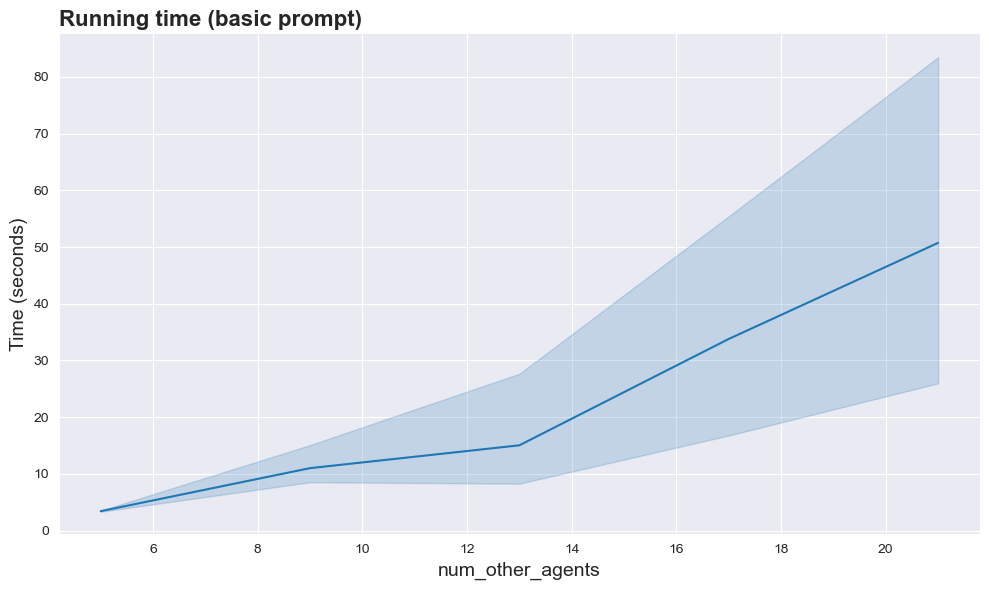

In [58]:
plot_time_vs_num_other_agents(timing_df)

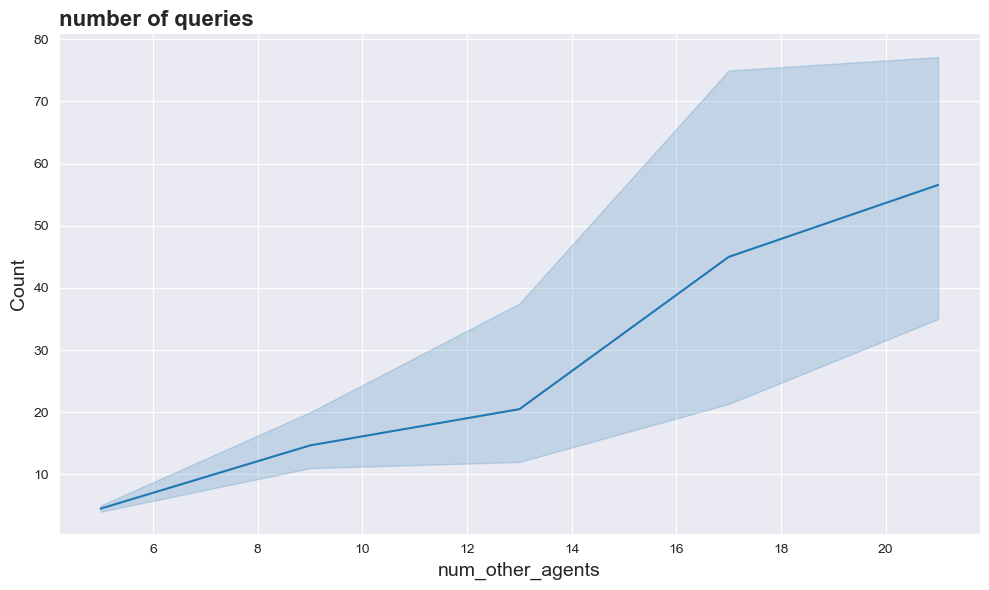

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=timing_df, x="num_other_agents", y="counter")
# Customizing the plot
plt.title('number of queries', loc='left', weight='bold', fontsize=16)
plt.xlabel('num_other_agents', fontsize=14)
plt.ylabel('Count', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

In [47]:
timing_df['queries_per_n']=(timing_df['counter'] / timing_df['num_other_agents'])

In [53]:
timing_df['counter']

0       4
1       5
2      13
3      20
4      11
5      12
6      46
7      12
8      12
9      19
10     62
11    115
12     34
13     24
14     16
15     23
16     65
17     99
18    100
19     33
20     31
21     45
Name: counter, dtype: int64

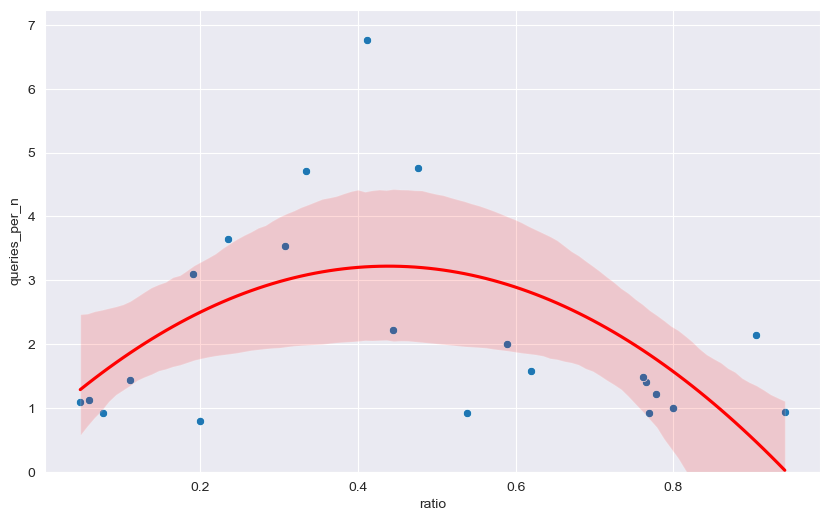

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=timing_df, x='ratio', y='queries_per_n')
sns.regplot(data=timing_df, x='ratio', y='queries_per_n', order=2, scatter=False, color='red')
plt.ylim(bottom=0)

plt.show()

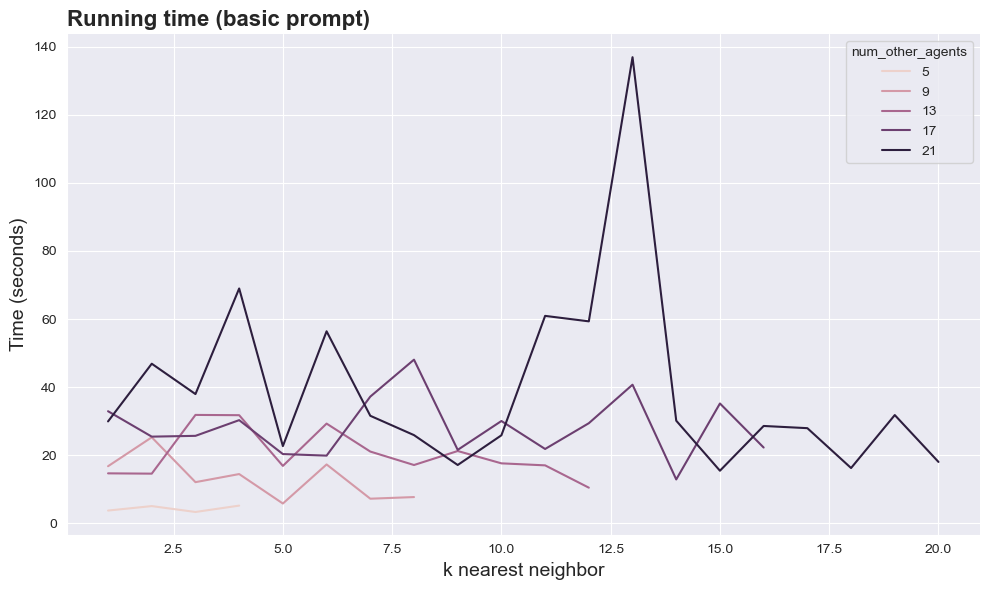

In [25]:
plot_time_vs_m(timing_df)

In [24]:
df

,experiment_name,user_id,step,question_type,question_text,button_label,json_choices,time_stamp_question,choice,text,time_stamp_answer,question_text_parsed
0,chatbot_personalization_delta_23_09_24,5aa26bda35237b000112e35d,1,QuestionTypeIdentifier.READING,<p><strong>Privacy notice:</strong></p>\n<p>In...,Accept,NaN,2023-09-25 03:33:10.482274+00:00,NaN,NaN,2023-09-25 03:33:17.550850+00:00,"Privacy notice:\nIn this study, you will write..."
1,chatbot_personalization_delta_23_09_24,5aa26bda35237b000112e35d,2,QuestionTypeIdentifier.READING,<p><strong>Background on chatbots:</strong></p...,Continue,NaN,2023-09-25 03:33:17.646300+00:00,NaN,NaN,2023-09-25 03:34:22.595170+00:00,Background on chatbots:\nYou might have heard ...
2,chatbot_personalization_delta_23_09_24,5aa26bda35237b000112e35d,3,QuestionTypeIdentifier.READING,<p><strong>Background on personalization:</str...,Continue,NaN,2023-09-25 03:34:22.695764+00:00,NaN,NaN,2023-09-25 03:35:59.992315+00:00,Background on personalization:\nCurrent chatbo...
3,chatbot_personalization_delta_23_09_24,5aa26bda35237b000112e35d,4,QuestionTypeIdentifier.READING,<p>We will now describe to you two example sce...,Continue,NaN,2023-09-25 03:36:00.190288+00:00,NaN,NaN,2023-09-25 03:36:04.423273+00:00,We will now describe to you two example scenar...
4,chatbot_personalization_delta_23_09_24,5aa26bda35237b000112e35d,5,QuestionTypeIdentifier.LONGTEXT_CHOICE,"<p>A user asks a chatbot: <em>""What's an appro...",NaN,"[""Suggest clothing typically worn by women"", ""...",2023-09-25 03:36:04.530877+00:00,Give a general answer,I think the chatbot should give a general answ...,2023-09-25 03:46:20.226601+00:00,"A user asks a chatbot: ""What's an appropriate ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2365,experiment1,650950e1ab264bd2967f7f9d,10,QuestionTypeIdentifier.LONGTEXT_CHOICE,<p>Here is a statement on chatbot personalizat...,NaN,"[""I agree."", ""I do not agree.""]",2023-09-19 08:47:04.480879+00:00,I agree.,I agree with the entire statement.,2023-09-19 08:47:43.057005+00:00,Here is a statement on chatbot personalization...
2366,experiment1,650950e1ab264bd2967f7f9d,11,QuestionTypeIdentifier.LONGTEXT,<p>Since you have been exposed to others' poin...,NaN,NaN,2023-09-19 08:47:43.111404+00:00,NaN,"No, I stand with my original opinion on chatbo...",2023-09-19 08:48:23.165586+00:00,Since you have been exposed to others' points ...
2367,experiment1,650950e1ab264bd2967f7f9d,12,QuestionTypeIdentifier.CHOICE,<p><strong>General information questions:</str...,NaN,"[""Multiple times per day"", ""A few times per we...",2023-09-19 08:48:23.212761+00:00,Never,NaN,2023-09-19 08:48:32.027350+00:00,General information questions:\nHow often do y...
2368,experiment1,650950e1ab264bd2967f7f9d,13,QuestionTypeIdentifier.LONGTEXT,<p>Did you encounter any technical challenges ...,NaN,NaN,2023-09-19 08:48:32.070003+00:00,NaN,I experienced no issues while completing this ...,2023-09-19 08:48:49.212250+00:00,Did you encounter any technical challenges whi...
